In [348]:
import numpy as np
import cv2
import matplotlib.pylab as plt

We load the image from the given file.

In [349]:
img = cv2.imread('./slic.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

We set the parameter K and compute needed information from that.

In [350]:
k = 64
number_of_pixels = img.shape[0] * img.shape[1]
average_area = number_of_pixels / k
S = average_area ** 0.5
average_height = img.shape[0] / np.sqrt(k)
average_width= img.shape[1] / np.sqrt(k)
number_of_pixels, average_area, S, average_height, average_width

(12192768, 190512.0, 436.4768035073571, 378.0, 504.0)

Here we generate K equally spaced coordinates on the plane.

In [351]:
x_coordinates = np.convolve(np.arange(0, img.shape[0] + S/ 2 , S), [0.5, 0.5], 'valid')
y_coordinates = np.convolve(np.arange(0, img.shape[1] + S/ 2 , S), [0.5, 0.5], 'valid')

We calculate gradient magnitude using sobel function.

In [352]:
ddepth = cv2.CV_64F
dx = cv2.Sobel(img, ddepth, 1, 0)
dy = cv2.Sobel(img, ddepth, 0, 1)
gradient = np.sqrt(dx**2 + dy**2)

We plot the selected points on empty plane.

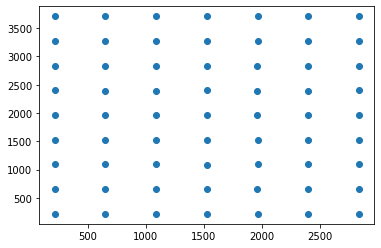

2839 3711


In [353]:
centroids = list()
for x in x_coordinates:
  for y in y_coordinates:
    min_gradient = float('inf')
    min_index= (0, 0)
    for x_dist in range(-2, 3):
      for y_dist in range(-2, 3):
        new_x, new_y = int(x + x_dist), int(y + y_dist)
        current_gradient = np.sum(gradient[new_x, new_y]**2)
        if current_gradient < min_gradient:
          min_gradient = current_gradient
          min_index = new_x, new_y
    centroids.append((min_index[0], min_index[1]))

X = np.array(centroids)[:,0]
Y = np.array(centroids)[:,1]
plt.scatter(X, Y)
plt.show()
print(np.max(X), np.max(Y))

We convert the image to Lab space to perform the segmentation.

In [354]:
lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

We genrate the 5 dimentional feature vector.

In [355]:
feature_vector = list()
for row in range(lab_img.shape[0]):
  for col in range(lab_img.shape[1]):
    L, a, b = lab_img[row, col]
    feature_vector.append((row, col, L, a, b))

In [356]:
feature_vector = np.array(feature_vector)
feature_vector.shape

(12192768, 5)

Here we set the m parameter. Alpha parameter is derived from **m/S** where S is average distance of neighbour points. 

In [357]:
m = 20
alpha=float(m/S)
feature_vector = feature_vector.reshape(img.shape[0], img.shape[1], -1)

Here we perform the main step. We assign each pixel to its closest centroid. Each centroid covers a 2Sx2S area.

| k     | 64       | 128      | 256      | 512      | 1024     | 2048     |
| ----- | -------- | -------- | -------- | -------- | -------- | -------- |
| alpha | 0.045821 | 0.064801 | 0.091643 | 0.129603 | 0.183286 | 0.259205 |

In [358]:
distance_matrix = np.ones(shape=img.shape[:2], dtype=np.float64) * float('inf')
label = np.zeros(shape=img.shape[:2], dtype=np.float32)
color_label = np.zeros(shape=img.shape[:2], dtype=np.int64)

for index, centroid in enumerate(centroids):
  x, y = centroid
  x_interval = np.uint16(np.arange(max(0, x-S), min(img.shape[0], x+S), 1))
  y_interval = np.uint16(np.arange(max(0, y-S), min(img.shape[1], y+S), 1))
  c = feature_vector[x, y]
  D = alpha * np.sum((feature_vector[x_interval[0]:x_interval[-1] + 1, y_interval[0]:y_interval[-1] + 1, :2]  - c[:2])**2,
              axis=-1) + np.sum((feature_vector[x_interval[0]:x_interval[-1] + 1, y_interval[0]:y_interval[-1] + 1, 2:]- c[2:])**2, axis=-1)
  color = np.random.randint(1, 256)
  for i, pixel_x in enumerate(x_interval):
    for j, pixel_y in enumerate(y_interval):
        distance = D[i, j]
        if distance < distance_matrix[pixel_x, pixel_y]:
          distance_matrix[pixel_x, pixel_y] = distance
          label[pixel_x, pixel_y] = color
          color_label[pixel_x, pixel_y] = index + 1

In [359]:
def normalize(img):
    return cv2.normalize(img, np.zeros(img.shape), 0, 255, cv2.NORM_MINMAX)

In [360]:
print('Alpha is :', m/S)

Alpha is : 0.045821449935684586


We draw edges after applying a small median filter.

In [361]:
edges = cv2.Canny(cv2.medianBlur(normalize(label).astype(np.uint8), 2 * int(S/40) + 1),0,1)
# cv2_imshow(edges)

In [362]:
from skimage.segmentation import mark_boundaries
regions = img.copy()
regions[edges > 0 ] = np.array([0, 0, 255])
# cv2_imshow(regions)
cv2.imwrite(f'res06.jpg', regions)

True

In [363]:
image_regions = img.copy()
for i in range(index+2):
  image_regions[color_label==i] = np.mean(img[color_label==i], axis=0)

cv2.imwrite(f'q3-{k}-only_mean-{alpha}.jpg', image_regions)

True

In [364]:
regions = image_regions.copy()
regions[edges > 0 ] = np.array([0, 0, 255])
# cv2_imshow(regions)
cv2.imwrite(f'q3-{k}-mean_color-{alpha}.jpg', regions)

True